You will need to install this

https://patsy.readthedocs.io/en/latest/overview.html#installation

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import optimisers
from BayesianOptimizer.Parameters import Parameter
from BayesianOptimizer.Distributions import Gaussian

So far we have been looking at linear models on the $\mu,\sigma,\xi$ parameters. Ideally, we would like to model non-linear things, for example
$$Y_i\sim \mathcal{N}(1-x_i^2, 0.5^2)$$
or
$$Y_i\sim\text{GEV}(1-x_i^2, x_i^2 + 0.5, 2x_i)$$

**Remark:** While our terms have quadratics (and possibly other polynomial degrees), it is still linear with respect to the basis $(1,x,x^2,x^3,\ldots)$, or any other polynomial expansion.

# Polynomial Regression

One simple way would be to perform polynomial regression

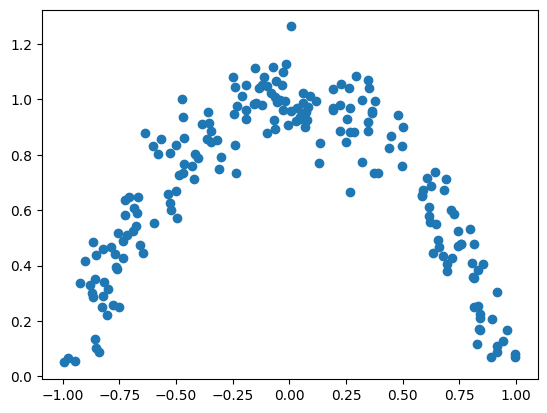

In [11]:
# Generating the data
x = (np.random.rand(200) - 0.5) * 2
Y = 1 - x ** 2 + np.random.normal(0, 0.1, size=len(x))
plt.scatter(x, Y)

In [12]:
X = torch.ones(len(x), 3, dtype=torch.float64)
X[:, 1] = torch.tensor(x, dtype=torch.float64)
X[:, 2] = torch.tensor(x ** 2, dtype=torch.float64)  # We have another variable to store x^2

tensor_Y = torch.tensor(Y, dtype=torch.float64)

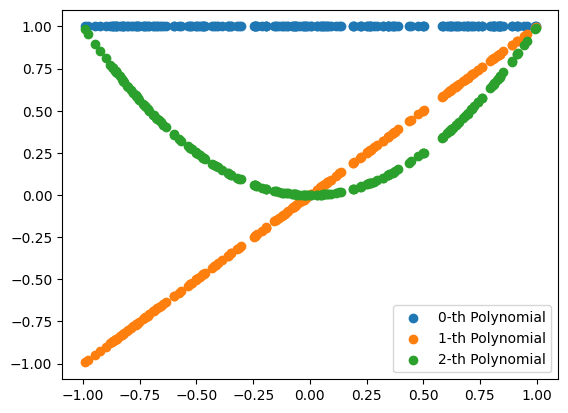

In [13]:
for i in range(X.shape[1]):
    plt.scatter(x, X[:, i], label=f"{i}-th Polynomial")
plt.legend();

In [14]:
class mu_param(Parameter):
    def __init__(self, X):
        self.X = X
    
    @staticmethod
    def log_prior(beta):
        return 0  # No Prior
    
    def __call__(self, beta):
        return beta @ self.X.T  # linear model (i.e. beta_0 + beta_1 x_i)
    
    def num_coefficients(self):
        return self.X.shape[-1]

In [15]:
likelihood = Gaussian(tensor_Y, mu=mu_param(X), sigma=0.5)

In [18]:
h = 0.001
beta = 2
num_particles = 10
dim = likelihood.num_parameters

optimizer = optimisers.OverdampedLangevin(h, beta, num_particles, dim, likelihood, is_valid=None,
                               which_discretization='euler', dtype=torch.float64)

In [21]:
num_iters = 2000
history, best_particle, best_val, best_iter = optimizer.run_with_history(num_iters, beta=0.01)
best_particle, best_val, best_iter

(tensor([ 1.0285, -0.0165, -0.9586], dtype=torch.float64),
 tensor(49.7840, dtype=torch.float64),
 582)

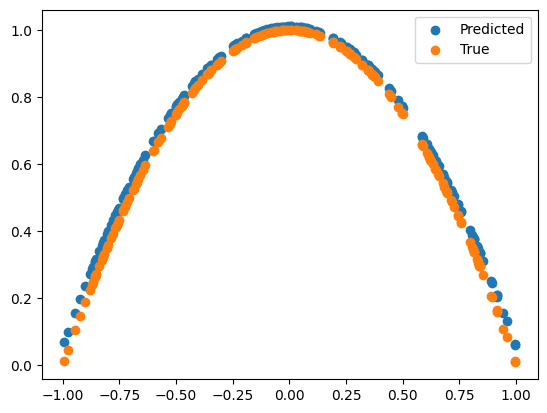

In [20]:
plt.scatter(x, X @ best_particle, label='Predicted')
plt.scatter(x, 1 - x ** 2, label='True')
plt.legend();

In [ ]:
history.shape

torch.Size([2000, 10, 3])

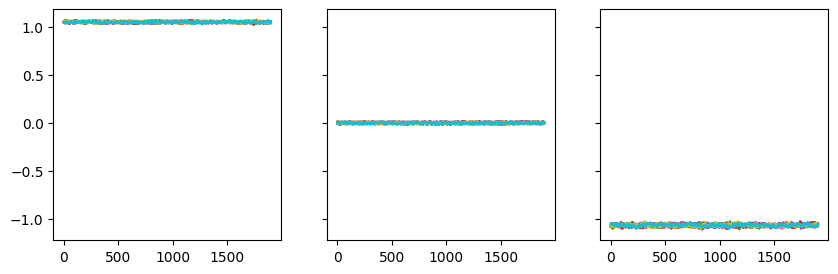

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for i in range(3):
    axs[i].plot(history[100:, :, i])

So we get the correct values.

# B-Splines

If we wanted to model higher degree polynomials, we can perform the same procedure and add higher order terms to our polynomial regression. However, this will cause massive numerical issues when running the code. Instead, we can use B-Splines (essentially an orthogonal polynomial) which will reduce the numerical instabilities. As such, our regression takes a new form
$$Y_i\sim \mathcal{N}\left(\sum_{k=0}^K a_k f_k(x_i)\right),$$
where $f_k$ is the $k$-th B-spline. Using a larger $K$ will give more flexibility to the model.

In [ ]:
from BayesianOptimizer.BasisFunctions import b_splines

In [ ]:
# df is the K
X = b_splines(x, df=3, include_bias=True, mean_zero=False)

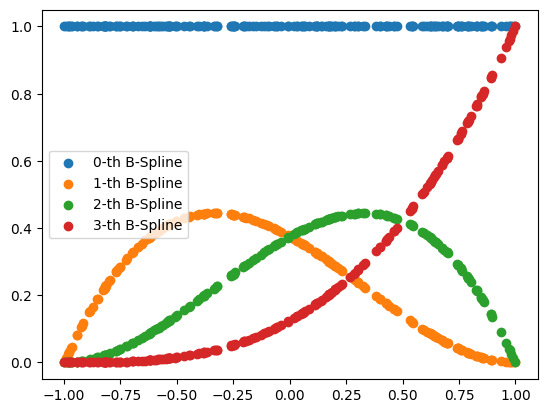

In [ ]:
for i in range(X.shape[1]):
    plt.scatter(x, X[:, i], label=f"{i}-th B-Spline")
plt.legend();

In [ ]:
likelihood = Gaussian(tensor_Y, mu=mu_param(X), sigma=0.5)

In [ ]:
h = 0.001
beta = 2
num_particles = 10
dim = likelihood.num_parameters

optimizer = OverdampedLangevin(h, beta, num_particles, dim, likelihood, is_valid=None,
                               which_discretization='euler', dtype=torch.float64)

In [ ]:
num_iters = 2000
history, best_particle, best_val, best_iter = optimizer.run_with_history(num_iters, beta=0.01)
best_particle, best_val, best_iter

(tensor([-0.0934,  1.7704,  1.2114,  0.1759], dtype=torch.float64),
 tensor(143.8960, dtype=torch.float64),
 1483)

Recall, our regression is now in terms of $f_k(x_i)$, thus the results do not line up with what we expect. Instead, we should plot what the predict values are from the B-spline expansion and plot it against the true predictions.

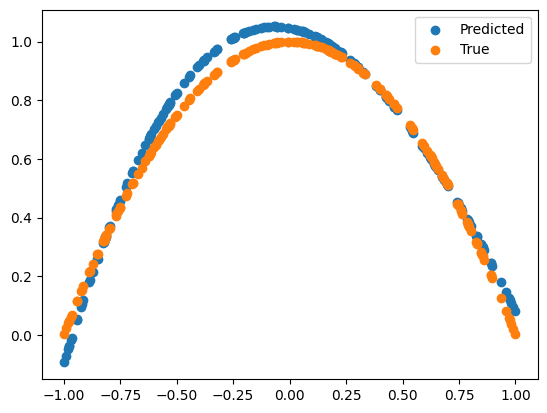

In [ ]:
plt.scatter(x, X @ best_particle, label='Predicted')
plt.scatter(x, 1 - x ** 2, label='True')
plt.legend();

You should see that this plot is similar, or the same, as when using polynomial regression.

**To Do:** Try higher $K$ values, and different models. For example
$$Y_i\sim\mathcal{N}(\sin(4 * x_i), 0.5^2)$$
Try this for the GEV example as well.